In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
import os
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from datetime import datetime
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.decomposition import PCA

### Data Cleaning

In [2]:
# First dataset to clean is the price_demand_data.
# Categorise PRICECATEGORY to extract the maximum value for groupby later.
pc = pd.CategoricalDtype(categories = ["LOW","MEDIUM","HIGH","EXTREME"], ordered=True)

# Unify date formate for both datasets to merge later.
df1 = pd.read_csv('price_demand_data.csv', 
    dtype = {'PRICECATEGORY': pc},
    parse_dates=['SETTLEMENTDATE'], dayfirst=True)
df1['Date'] = df1['SETTLEMENTDATE'].dt.date

# Second dataset is the weather_data.
df2 = pd.read_csv('weather_data.csv',
    index_col = 'Date', parse_dates=['Date'], dayfirst=True)

# Select maximum value as the daily energy demand
max_demand = df1.groupby('Date').agg({'TOTALDEMAND': "max", 'PRICECATEGORY': "max"})

# Merge two datasets.
df_new = pd.merge(max_demand, df2, left_index=True, right_index=True)

df_new

,TOTALDEMAND,PRICECATEGORY,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5019.64,LOW,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
2021-01-02,4964.35,LOW,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2021-01-03,4503.31,LOW,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
2021-01-04,4764.18,LOW,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
2021-01-05,4800.64,LOW,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,6769.89,EXTREME,4.6,13.6,0.0,1.2,3.8,SSW,15.0,12:18,...,7,,Calm,1020.0,12.8,65,7.0,SSE,7,1017.4
2021-08-28,5716.32,MEDIUM,5.3,17.8,0.0,1.6,9.6,N,39.0,13:14,...,1,N,7,1018.6,17.4,31,3.0,NNW,24,1013.5
2021-08-29,6227.89,EXTREME,9.1,16.2,0.6,6.4,4.3,NNE,33.0,1:50,...,7,N,13,1011.4,12.8,84,7.0,S,6,1010.4


In [3]:
# Noticed in 9am & 3pm Wind speed column has non-numeric data 'Calm'
df_new.loc[df_new['9am wind speed (km/h)'].str.upper()=='CALM', '9am wind speed (km/h)'] = 1
df_new.loc[df_new['3pm wind speed (km/h)'].str.upper()=='CALM', '3pm wind speed (km/h)'] = 1
df_new

,TOTALDEMAND,PRICECATEGORY,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5019.64,LOW,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
2021-01-02,4964.35,LOW,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2021-01-03,4503.31,LOW,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
2021-01-04,4764.18,LOW,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
2021-01-05,4800.64,LOW,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,6769.89,EXTREME,4.6,13.6,0.0,1.2,3.8,SSW,15.0,12:18,...,7,,1,1020.0,12.8,65,7.0,SSE,7,1017.4
2021-08-28,5716.32,MEDIUM,5.3,17.8,0.0,1.6,9.6,N,39.0,13:14,...,1,N,7,1018.6,17.4,31,3.0,NNW,24,1013.5
2021-08-29,6227.89,EXTREME,9.1,16.2,0.6,6.4,4.3,NNE,33.0,1:50,...,7,N,13,1011.4,12.8,84,7.0,S,6,1010.4


In [4]:
# Convert time in "hh:mm" format to number of minutes
def time(timestring):
    if type(timestring) == str and ':' in timestring:
        hour, minute = str(timestring).split(':')
        return int(hour)*60 + int(minute)

df_new['Time of maximum wind gust'] = df_new['Time of maximum wind gust'].apply(time)
df_new

,TOTALDEMAND,PRICECATEGORY,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5019.64,LOW,15.6,29.9,0.0,2.8,9.3,NNE,31.0,794.0,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
2021-01-02,4964.35,LOW,18.4,29.0,0.0,9.4,1.3,NNW,30.0,502.0,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2021-01-03,4503.31,LOW,17.0,26.2,12.6,4.8,7.1,WSW,33.0,1075.0,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
2021-01-04,4764.18,LOW,16.0,18.6,2.6,3.8,0.0,SSE,41.0,963.0,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
2021-01-05,4800.64,LOW,15.9,19.1,11.2,1.0,0.0,SSE,35.0,662.0,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,6769.89,EXTREME,4.6,13.6,0.0,1.2,3.8,SSW,15.0,738.0,...,7,,1,1020.0,12.8,65,7.0,SSE,7,1017.4
2021-08-28,5716.32,MEDIUM,5.3,17.8,0.0,1.6,9.6,N,39.0,794.0,...,1,N,7,1018.6,17.4,31,3.0,NNW,24,1013.5
2021-08-29,6227.89,EXTREME,9.1,16.2,0.6,6.4,4.3,NNE,33.0,110.0,...,7,N,13,1011.4,12.8,84,7.0,S,6,1010.4


In [5]:
# Determin null values in the new merged dataset
df_new.isnull().sum()

TOTALDEMAND                          0
PRICECATEGORY                        0
Minimum temperature (°C)             1
Maximum temperature (°C)             1
Rainfall (mm)                        2
Evaporation (mm)                     0
Sunshine (hours)                     0
Direction of maximum wind gust       3
Speed of maximum wind gust (km/h)    3
Time of maximum wind gust            3
9am Temperature (°C)                 1
9am relative humidity (%)            1
9am cloud amount (oktas)             0
9am wind direction                   1
9am wind speed (km/h)                1
9am MSL pressure (hPa)               2
3pm Temperature (°C)                 0
3pm relative humidity (%)            0
3pm cloud amount (oktas)             1
3pm wind direction                   0
3pm wind speed (km/h)                0
3pm MSL pressure (hPa)               1
dtype: int64

In [6]:
# Fill in some NaN value
df_new = df_new.fillna(df_new.mean())
df_new

,TOTALDEMAND,PRICECATEGORY,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5019.64,LOW,15.6,29.9,0.0,2.8,9.3,NNE,31.0,794.0,...,6,N,2,1018.800000,28.1,43,5.0,E,13,1015.3
2021-01-02,4964.35,LOW,18.4,29.0,0.0,9.4,1.3,NNW,30.0,502.0,...,7,NNW,17,1013.300000,28.7,38,7.0,SW,4,1008.5
2021-01-03,4503.31,LOW,17.0,26.2,12.6,4.8,7.1,WSW,33.0,1075.0,...,8,WSW,4,1007.700000,23.5,59,4.0,SSW,2,1005.2
2021-01-04,4764.18,LOW,16.0,18.6,2.6,3.8,0.0,SSE,41.0,963.0,...,8,SSE,11,1010.000000,18.2,82,8.0,SSW,17,1011.0
2021-01-05,4800.64,LOW,15.9,19.1,11.2,1.0,0.0,SSE,35.0,662.0,...,8,SSE,13,1012.500000,18.2,82,8.0,SSE,19,1013.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,6769.89,EXTREME,4.6,13.6,0.0,1.2,3.8,SSW,15.0,738.0,...,7,,1,1020.000000,12.8,65,7.0,SSE,7,1017.4
2021-08-28,5716.32,MEDIUM,5.3,17.8,0.0,1.6,9.6,N,39.0,794.0,...,1,N,7,1018.600000,17.4,31,3.0,NNW,24,1013.5
2021-08-29,6227.89,EXTREME,9.1,16.2,0.6,6.4,4.3,NNE,33.0,110.0,...,7,N,13,1011.400000,12.8,84,7.0,S,6,1010.4


In [7]:
# Check NaN value again
df_new.isnull().sum()

TOTALDEMAND                          0
PRICECATEGORY                        0
Minimum temperature (°C)             0
Maximum temperature (°C)             0
Rainfall (mm)                        0
Evaporation (mm)                     0
Sunshine (hours)                     0
Direction of maximum wind gust       3
Speed of maximum wind gust (km/h)    0
Time of maximum wind gust            0
9am Temperature (°C)                 0
9am relative humidity (%)            0
9am cloud amount (oktas)             0
9am wind direction                   1
9am wind speed (km/h)                1
9am MSL pressure (hPa)               0
3pm Temperature (°C)                 0
3pm relative humidity (%)            0
3pm cloud amount (oktas)             0
3pm wind direction                   0
3pm wind speed (km/h)                0
3pm MSL pressure (hPa)               0
dtype: int64

In [8]:
df_new = df_new.ffill()
df_new

,TOTALDEMAND,PRICECATEGORY,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,5019.64,LOW,15.6,29.9,0.0,2.8,9.3,NNE,31.0,794.0,...,6,N,2,1018.800000,28.1,43,5.0,E,13,1015.3
2021-01-02,4964.35,LOW,18.4,29.0,0.0,9.4,1.3,NNW,30.0,502.0,...,7,NNW,17,1013.300000,28.7,38,7.0,SW,4,1008.5
2021-01-03,4503.31,LOW,17.0,26.2,12.6,4.8,7.1,WSW,33.0,1075.0,...,8,WSW,4,1007.700000,23.5,59,4.0,SSW,2,1005.2
2021-01-04,4764.18,LOW,16.0,18.6,2.6,3.8,0.0,SSE,41.0,963.0,...,8,SSE,11,1010.000000,18.2,82,8.0,SSW,17,1011.0
2021-01-05,4800.64,LOW,15.9,19.1,11.2,1.0,0.0,SSE,35.0,662.0,...,8,SSE,13,1012.500000,18.2,82,8.0,SSE,19,1013.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-27,6769.89,EXTREME,4.6,13.6,0.0,1.2,3.8,SSW,15.0,738.0,...,7,,1,1020.000000,12.8,65,7.0,SSE,7,1017.4
2021-08-28,5716.32,MEDIUM,5.3,17.8,0.0,1.6,9.6,N,39.0,794.0,...,1,N,7,1018.600000,17.4,31,3.0,NNW,24,1013.5
2021-08-29,6227.89,EXTREME,9.1,16.2,0.6,6.4,4.3,NNE,33.0,110.0,...,7,N,13,1011.400000,12.8,84,7.0,S,6,1010.4


In [9]:
df_new.isnull().sum()

TOTALDEMAND                          0
PRICECATEGORY                        0
Minimum temperature (°C)             0
Maximum temperature (°C)             0
Rainfall (mm)                        0
Evaporation (mm)                     0
Sunshine (hours)                     0
Direction of maximum wind gust       0
Speed of maximum wind gust (km/h)    0
Time of maximum wind gust            0
9am Temperature (°C)                 0
9am relative humidity (%)            0
9am cloud amount (oktas)             0
9am wind direction                   0
9am wind speed (km/h)                0
9am MSL pressure (hPa)               0
3pm Temperature (°C)                 0
3pm relative humidity (%)            0
3pm cloud amount (oktas)             0
3pm wind direction                   0
3pm wind speed (km/h)                0
3pm MSL pressure (hPa)               0
dtype: int64

In [10]:
df_new.dtypes

TOTALDEMAND                          float64
PRICECATEGORY                         object
Minimum temperature (°C)             float64
Maximum temperature (°C)             float64
Rainfall (mm)                        float64
Evaporation (mm)                     float64
Sunshine (hours)                     float64
Direction of maximum wind gust        object
Speed of maximum wind gust (km/h)    float64
Time of maximum wind gust            float64
9am Temperature (°C)                 float64
9am relative humidity (%)            float64
9am cloud amount (oktas)               int64
9am wind direction                    object
9am wind speed (km/h)                 object
9am MSL pressure (hPa)               float64
3pm Temperature (°C)                 float64
3pm relative humidity (%)              int64
3pm cloud amount (oktas)             float64
3pm wind direction                    object
3pm wind speed (km/h)                 object
3pm MSL pressure (hPa)               float64
dtype: obj

In [11]:
# Coverting all "object" dtypes into numeric dtypes. 
# Firstly, convert PRICECATEGORY values. 
df_new['PRICECATEGORY'] = df_new['PRICECATEGORY'].replace('LOW', 1)
df_new['PRICECATEGORY'] = df_new['PRICECATEGORY'].replace('MEDIUM', 2)
df_new['PRICECATEGORY'] = df_new['PRICECATEGORY'].replace('HIGH', 3)
df_new['PRICECATEGORY'] = df_new['PRICECATEGORY'].replace('EXTREME', 4)

# Secondly, convert 16 wind directions into numbers by times 22.5(360 degrees/16)
wd = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW']
wd_map = {wd[i]:i*22.5 for i in range(len(wd))}
df_new['Direction of maximum wind gust '] = df_new['Direction of maximum wind gust '].map(wd_map)
df_new['9am wind direction'] = df_new['9am wind direction'].map(wd_map)
df_new['3pm wind direction'] = df_new['3pm wind direction'].map(wd_map)

# Lastly, unify wind speed in numeric form
df_new["9am wind speed (km/h)"] = df_new["9am wind speed (km/h)"].astype(float)
df_new["3pm wind speed (km/h)"] = df_new["3pm wind speed (km/h)"].astype(float)

df_new.dtypes

TOTALDEMAND                          float64
PRICECATEGORY                          int64
Minimum temperature (°C)             float64
Maximum temperature (°C)             float64
Rainfall (mm)                        float64
Evaporation (mm)                     float64
Sunshine (hours)                     float64
Direction of maximum wind gust       float64
Speed of maximum wind gust (km/h)    float64
Time of maximum wind gust            float64
9am Temperature (°C)                 float64
9am relative humidity (%)            float64
9am cloud amount (oktas)               int64
9am wind direction                   float64
9am wind speed (km/h)                float64
9am MSL pressure (hPa)               float64
3pm Temperature (°C)                 float64
3pm relative humidity (%)              int64
3pm cloud amount (oktas)             float64
3pm wind direction                   float64
3pm wind speed (km/h)                float64
3pm MSL pressure (hPa)               float64
dtype: obj

In [ ]:
# Created cleaned & merged dataset for other teammates for their analysis. 
df_new.to_csv("cleaned_data_final.csv")

### Data Exploration

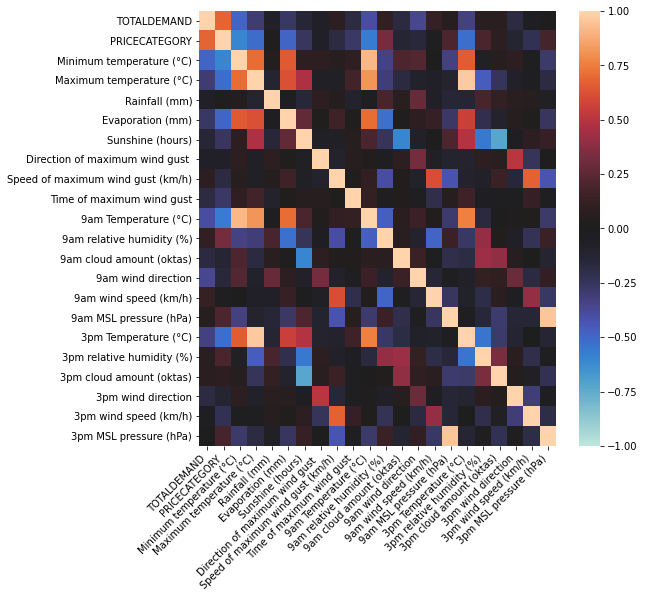

Grouped by direction, the top 5 Pearson correlation coefficients relating to price demand are listed below:
Strongest ranked postive coefficients


TOTALDEMAND                          1.000000
PRICECATEGORY                        0.685448
9am wind speed (km/h)                0.117655
9am relative humidity (%)            0.103267
Speed of maximum wind gust (km/h)    0.081024
3pm cloud amount (oktas)             0.070940
Name: TOTALDEMAND, dtype: float64

Strongest ranked negative coefficients


Minimum temperature (°C)   -0.488244
9am Temperature (°C)       -0.390843
9am wind direction         -0.356014
3pm Temperature (°C)       -0.325252
Maximum temperature (°C)   -0.290004
Name: TOTALDEMAND, dtype: float64

This chart highlights tthe comparative size and strength of coefficients favours a downward trend


In [12]:
# Create correlation matrix
df_pc = df_new.corr(method='pearson')

plt.figure(figsize=(8,8))

# Plot colour co-ordinated confusion matrix of coefficent relationships
ax = sns.heatmap(
    df_pc, 
    annot = False,
    vmin=-1, vmax=1, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    square=False,
)

# Set matrix labels
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

# Output Pearson's correlation for each dataset category 
print("Grouped by direction, the top 5 Pearson correlation coefficients relating to price demand are listed below:")

# Strongest ranked 5 postive coefficients

print("Strongest ranked postive coefficients")
display(df_pc['TOTALDEMAND'].sort_values(ascending=False)[0:6])

# Strongest ranked 5 negative coefficient weights

print("Strongest ranked negative coefficients")
display(df_pc['TOTALDEMAND'].sort_values()[0:5])
print("This chart highlights tthe comparative size and strength of coefficients favours a downward trend")

### Feature Engineering

In [ ]:
# Identify top features to correlate with daily max energy demand.
# 'PRICECATEGORY'
# 'Minimum temperature'
# '9am Temperature'
# '3pm Temperature'                 
# 'Maximum temperature'             
# 'Evaporation'  

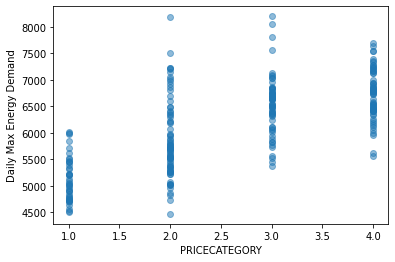

In [13]:
plt.scatter(x = df_new['PRICECATEGORY'], y = df_new['TOTALDEMAND'], alpha = 0.5)
plt.xlabel('PRICECATEGORY')
plt.ylabel('Daily Max Energy Demand')
plt.show()

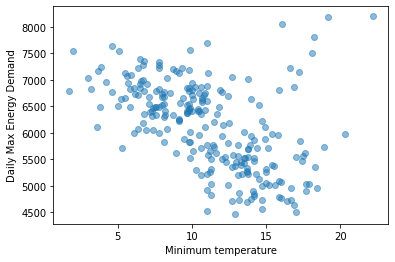

In [14]:
plt.scatter(x = df_new['Minimum temperature (°C)'], y = df_new['TOTALDEMAND'], alpha = 0.5)
plt.xlabel('Minimum temperature')
plt.ylabel('Daily Max Energy Demand')
plt.show()

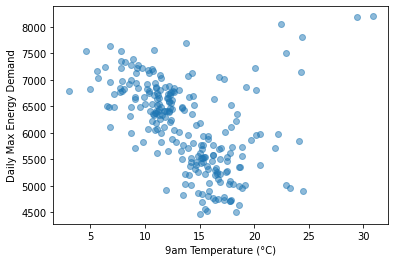

In [15]:
plt.scatter(x = df_new['9am Temperature (°C)'], y = df_new['TOTALDEMAND'], alpha = 0.5)
plt.xlabel('9am Temperature (°C)')
plt.ylabel('Daily Max Energy Demand')
plt.show()

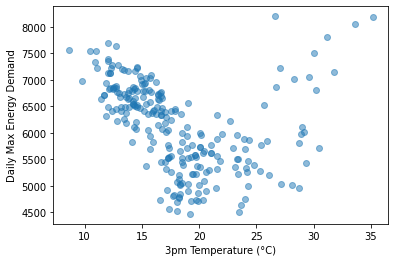

In [16]:
plt.scatter(x = df_new['3pm Temperature (°C)'], y = df_new['TOTALDEMAND'], alpha = 0.5)
plt.xlabel('3pm Temperature (°C)')
plt.ylabel('Daily Max Energy Demand')
plt.show()

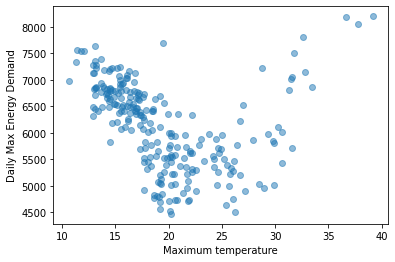

In [17]:
plt.scatter(x = df_new['Maximum temperature (°C)'], y = df_new['TOTALDEMAND'], alpha = 0.5)
plt.xlabel('Maximum temperature')
plt.ylabel('Daily Max Energy Demand')
plt.show()

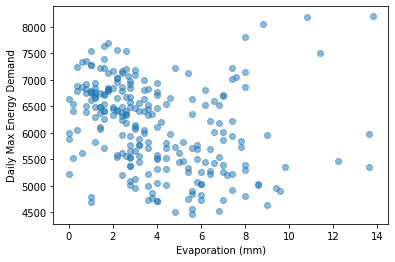

In [18]:
plt.scatter(x = df_new['Evaporation (mm)'], y = df_new['TOTALDEMAND'], alpha = 0.5)
plt.xlabel('Evaporation (mm)')
plt.ylabel('Daily Max Energy Demand')
plt.show()

Text(0.5, 0.98, 'Correlation between Weather and Energy Consumption')

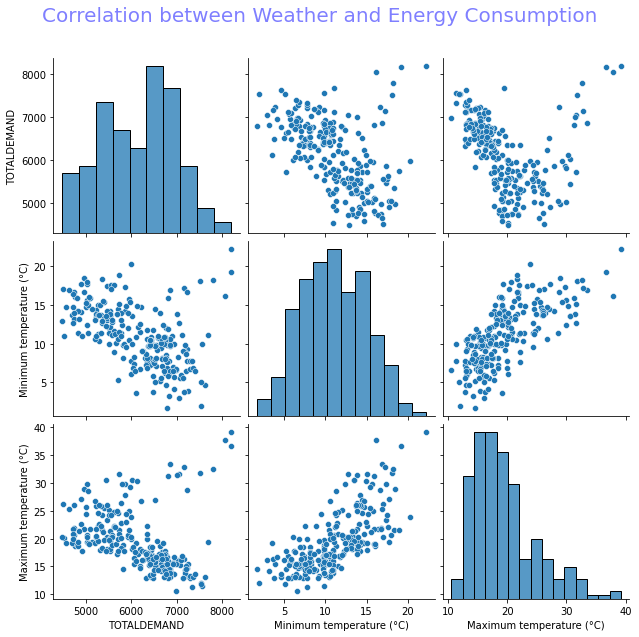

In [19]:
# TOTAL DEMAND vs MIN TEMP & MAX TEMP 
#Note height decides the size of the graph and palette decides the colour.
a=sns.pairplot(df_new,palette="muted",height=3,vars=['TOTALDEMAND','Minimum temperature (°C)','Maximum temperature (°C)'],kind='scatter',markers=['o','x','+'])

# Change the size of scatterpoints
a=a.map_offdiag(plt.scatter,s=35,alpha=0.9)

# Remove top and right lines
sns.despine()

# Add additional line to adjust some appearance issues
plt.subplots_adjust(top=0.9)

#Set up title of graph
a.fig.suptitle('Correlation between Weather and Energy Consumption',fontsize=20,color='b',alpha=0.5)

Text(0.5, 0.98, 'Correlation between Weather and Price Demand')

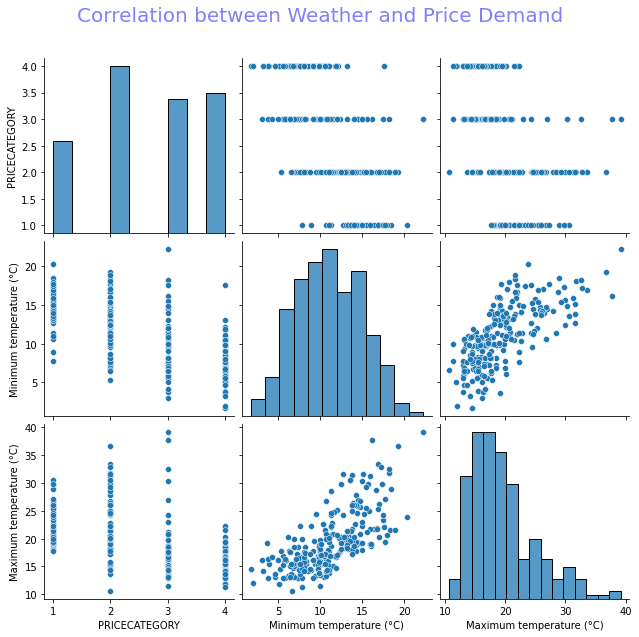

In [20]:
# PRICE CATEGORY vs MIN TEMP & MAX TEMP
a=sns.pairplot(df_new,palette="muted",height=3,vars=['PRICECATEGORY','Minimum temperature (°C)','Maximum temperature (°C)'],kind='scatter',markers=['o','x','+'])

# Change the size of scatterpoints
a=a.map_offdiag(plt.scatter,s=35,alpha=0.9)

# Remove top and right lines
sns.despine()

# Add additional line to adjust some appearance issues
plt.subplots_adjust(top=0.9)

#Set up title of graph
a.fig.suptitle('Correlation between Weather and Price Demand',fontsize=20,color='b',alpha=0.5)

Text(0.5, 0.98, 'Correlation between Morning & Afternoon Weather and Energy Consumption')

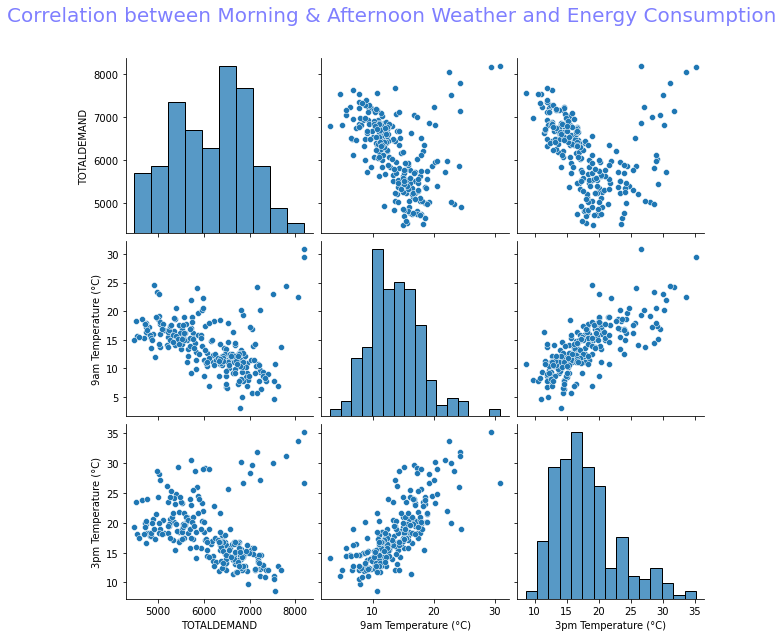

In [21]:
# TOTAL DEMAND vs 9am TEMP & 3pm TEMP
a=sns.pairplot(df_new,palette="muted",height=3,vars=['TOTALDEMAND','9am Temperature (°C)','3pm Temperature (°C)'],kind='scatter',markers=['o','x','+'])

# Change the size of scatterpoints
a=a.map_offdiag(plt.scatter,s=35,alpha=0.9)

# Remove top and right lines
sns.despine()

# Add additional line to adjust some appearance issues
plt.subplots_adjust(top=0.9)

#Set up title of graph
a.fig.suptitle('Correlation between Morning & Afternoon Weather and Energy Consumption',fontsize=20,color='b',alpha=0.5)

Text(0.5, 0.98, 'Correlation between Morning & Afternoon Weather and Price Demand')

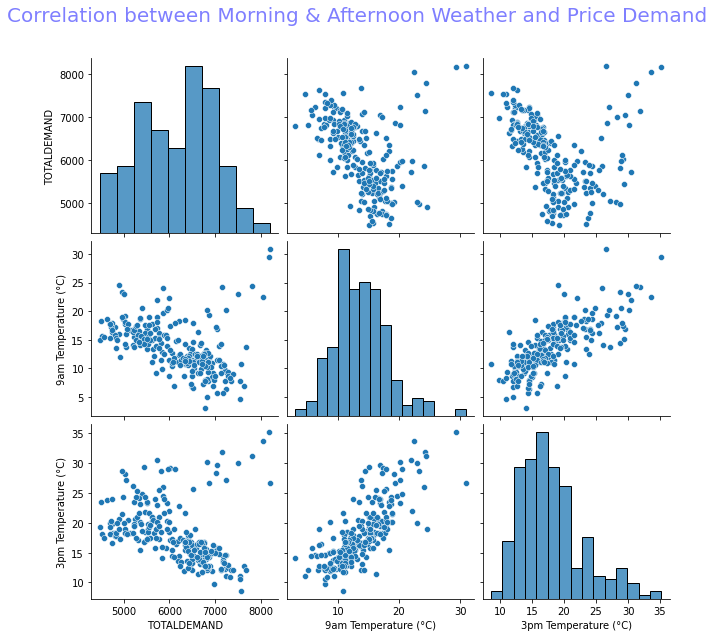

In [22]:
# PRICE CATEGORY vs 9am TEMP & 3pm TEMP
a=sns.pairplot(df_new,palette="muted",height=3,vars=['TOTALDEMAND','9am Temperature (°C)','3pm Temperature (°C)'],kind='scatter',markers=['o','x','+'])

# Change the size of scatterpoints
a=a.map_offdiag(plt.scatter,s=35,alpha=0.9)

# Remove top and right lines
sns.despine()

# Add additional line to adjust some appearance issues
plt.subplots_adjust(top=0.9)

#Set up title of graph
a.fig.suptitle('Correlation between Morning & Afternoon Weather and Price Demand',fontsize=20,color='b',alpha=0.5)

### Seaborn Scatterplots displaying variables plotted against each other

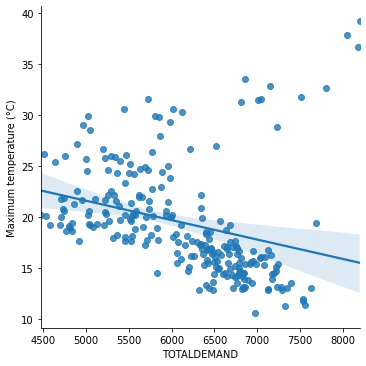

In [23]:
# Plotting a regular line = TOTAL DEMAND vs MAX TEMP
sns.lmplot(x="TOTALDEMAND", y="Maximum temperature (°C)", data=df_new)

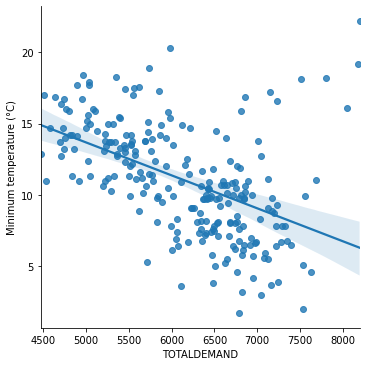

In [24]:
# Plotting a regular line = TOTAL DEMAND vs MIN TEMP
sns.lmplot(x="TOTALDEMAND", y="Minimum temperature (°C)", data=df_new)

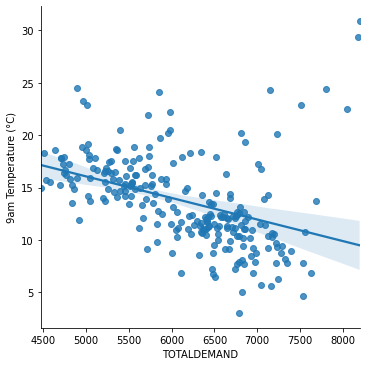

In [25]:
# Plotting a regular line = TOTAL DEMAND vs 9AM TEMP
sns.lmplot(x="TOTALDEMAND", y="9am Temperature (°C)", data=df_new)

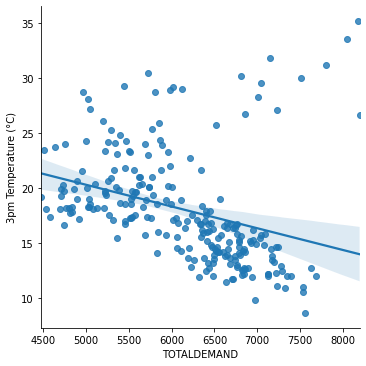

In [26]:
# Plotting a regular line = TOTAL DEMAND vs 3PM TEMP
sns.lmplot(x="TOTALDEMAND", y="3pm Temperature (°C)", data=df_new)

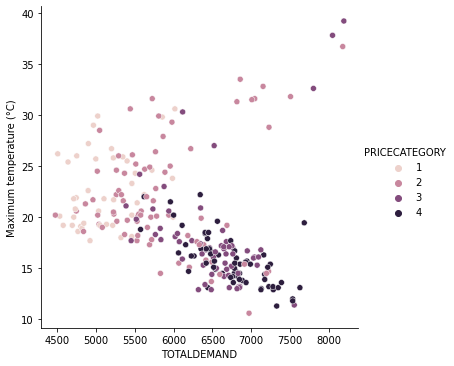

In [27]:
#Total Demand vs Max temp with overlay of color-coded price categories

sns.relplot(x="TOTALDEMAND", y="Maximum temperature (°C)", hue="PRICECATEGORY", data=df_new);

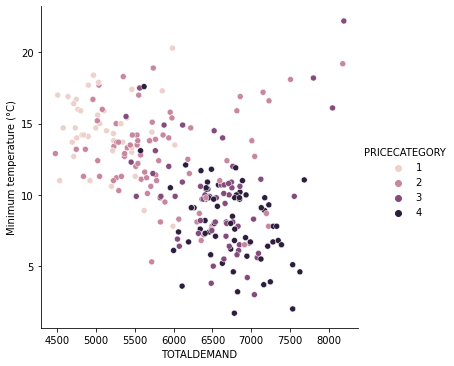

In [28]:
#Total Demand vs Min temp with overlay of color-coded price categories.

sns.relplot(x="TOTALDEMAND", y="Minimum temperature (°C)", hue="PRICECATEGORY", data=df_new);

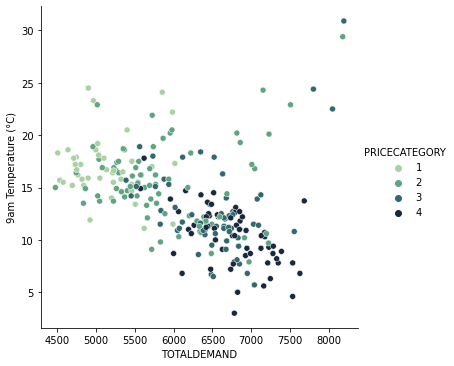

In [29]:
#Total Demand vs 9am temp with overlay of color-coded price categories

sns.relplot(x="TOTALDEMAND", y="9am Temperature (°C)", hue="PRICECATEGORY", palette="ch:r=-.5,l=.75", data=df_new);

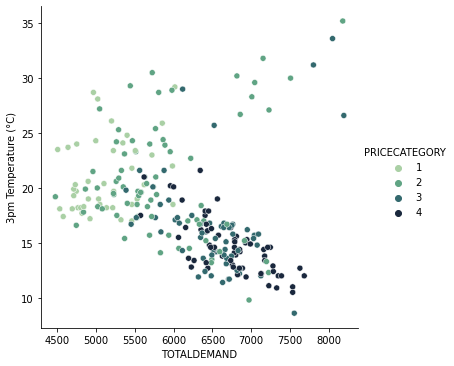

In [30]:
#Total Demand vs 9am temp with overlay of color-coded price categories

sns.relplot(x="TOTALDEMAND", y="3pm Temperature (°C)", hue="PRICECATEGORY", palette="ch:r=-.5,l=.75", data=df_new);

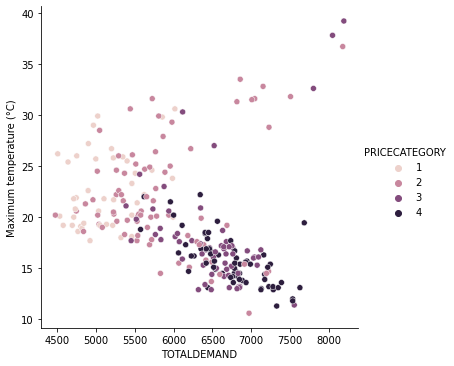

In [31]:
# Figure-level interface for drawing relational plots onto a FacetGrid
# This function provides access to several different axes-level functions that show the relationship between two variables with semantic mappings of subsets.
# TOTALDEMAND versus Maximum Temperature with overlay of colour-coded price categories

sns.relplot(x="TOTALDEMAND", y="Maximum temperature (°C)", hue="PRICECATEGORY", data=df_new);

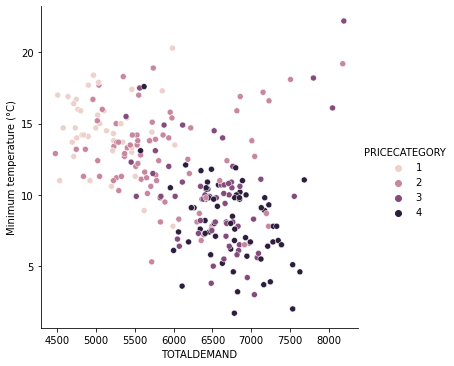

In [32]:
# TOTALDEMAND versus Minimum Temperature with overlay of colour-coded price categories

sns.relplot(x="TOTALDEMAND", y="Minimum temperature (°C)", hue="PRICECATEGORY", data=df_new);

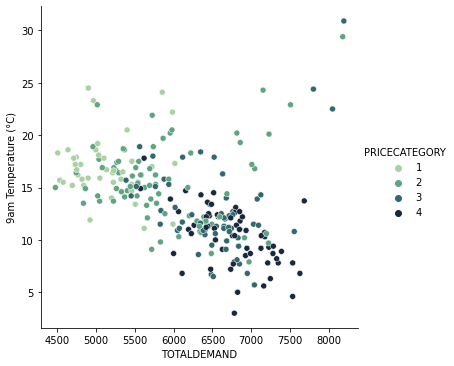

In [33]:
# TOTALDEMAND versus 9am Temperature with overlay of colour-coded price categories

sns.relplot(x="TOTALDEMAND", y="9am Temperature (°C)", hue="PRICECATEGORY", palette="ch:r=-.5,l=.75", data=df_new);

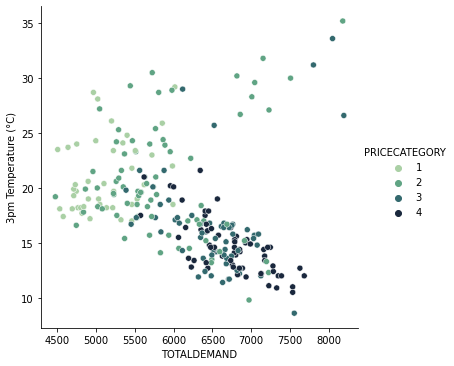

In [34]:
# TOTALDEMAND vs 3pm Temperature with overlay of colour-coded price categories

sns.relplot(x="TOTALDEMAND", y="3pm Temperature (°C)", hue="PRICECATEGORY", palette="ch:r=-.5,l=.75", data=df_new);

#### Histogram testing

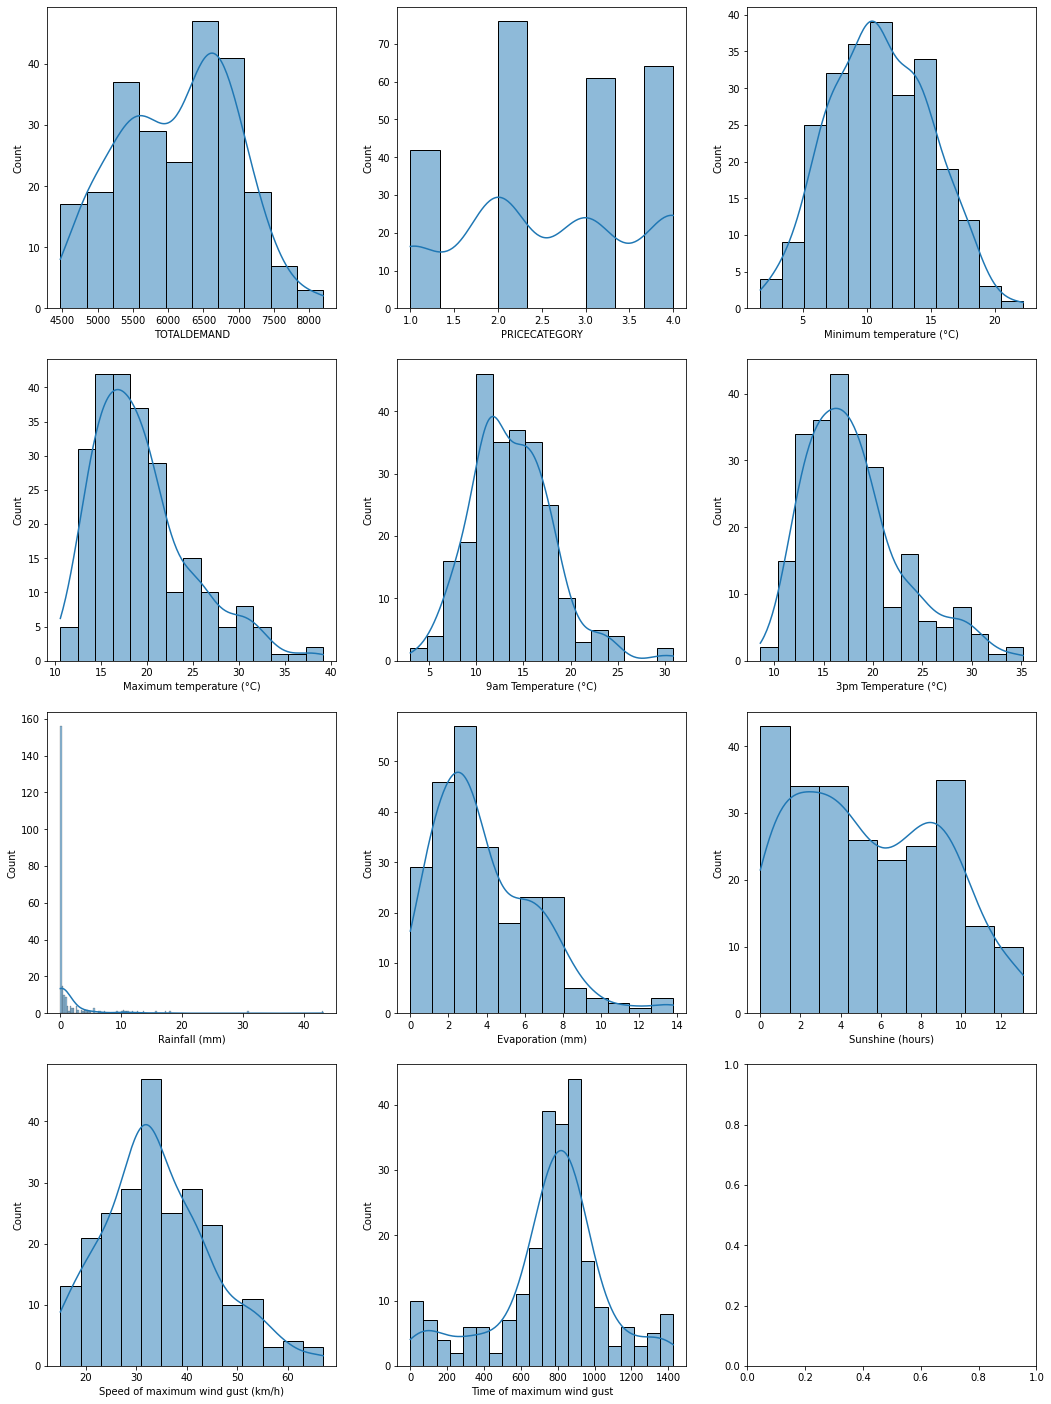

In [35]:
# Histograms showing distribution of numberical data associated with various features/characteristics
# Setup on a grid-like axis, for comparative analysis

fig, axes = plt.subplots(4,3, figsize=(15,20))
fig.tight_layout(pad=3.0)

cleaned_data = pd.read_csv('cleaned_data_final.csv')
sns.histplot(x = 'TOTALDEMAND', data = cleaned_data, kde = True, ax = axes[0,0]);
sns.histplot(x = 'PRICECATEGORY', data = cleaned_data, kde = True, ax = axes[0,1]);
sns.histplot(x = 'Minimum temperature (°C)', data = cleaned_data, kde = True, ax = axes[0,2]);
sns.histplot(x = 'Maximum temperature (°C)', data = cleaned_data, kde = True, ax = axes[1,0]);
sns.histplot(x = '9am Temperature (°C)', data = cleaned_data, kde = True, ax = axes[1,1]);
sns.histplot(x = '3pm Temperature (°C)', data = cleaned_data, kde = True, ax = axes[1,2]);
sns.histplot(x = 'Rainfall (mm)', data = cleaned_data, kde = True, ax = axes[2,0]);
sns.histplot(x = 'Evaporation (mm)', data = cleaned_data, kde = True, ax = axes[2,1]);
sns.histplot(x = 'Sunshine (hours)', data = cleaned_data, kde = True, ax = axes[2,2]);
sns.histplot(x = 'Speed of maximum wind gust (km/h)', data = cleaned_data, kde = True, ax = axes[3,0]);
sns.histplot(x = 'Time of maximum wind gust', data = cleaned_data, kde = True, ax = axes[3,1]);

#### Pairplot Testing

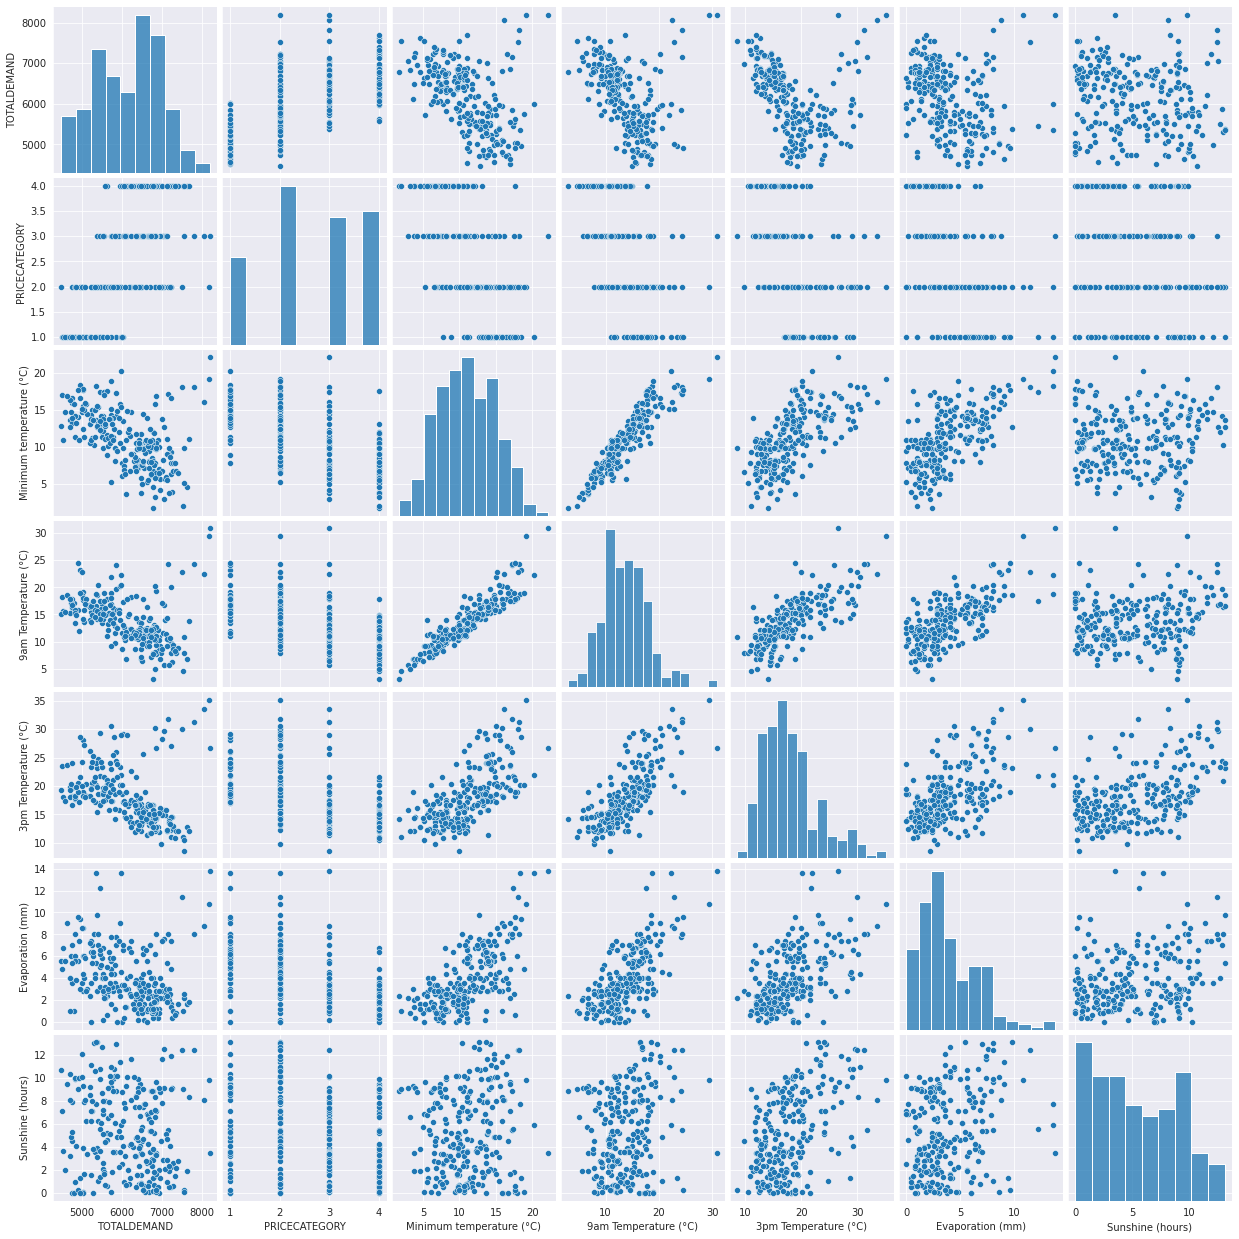

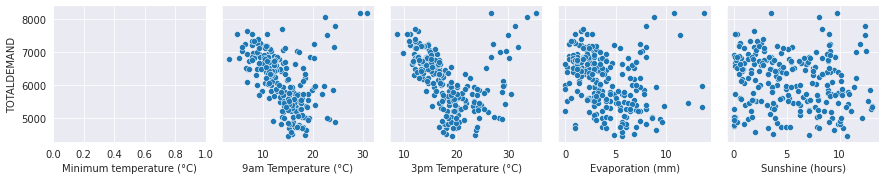

In [36]:
# Linear regression assumes that all attributes correlate linearly with the target 
# Is that actually the case in a real dataset? 
# Let us examine some relationships between certain attributes and the target

cleaned_data = pd.read_csv('cleaned_data_final.csv')
sns.set_style('darkgrid')
sns.pairplot(cleaned_data, vars = ['TOTALDEMAND', 'PRICECATEGORY', 'Minimum temperature (°C)', '9am Temperature (°C)', '3pm Temperature (°C)', 'Evaporation (mm)', 'Sunshine (hours)'])
sns.pairplot(cleaned_data,
             x_vars=['Minimum temperature (°C)', '9am Temperature (°C)', '3pm Temperature (°C)', 'Evaporation (mm)', 'Sunshine (hours)'], 
             y_vars=['TOTALDEMAND'])
plt.show()

# Predictive Modeling

## LINEAR REGRESSION

### Model 1

In [37]:
Y = df_new['TOTALDEMAND']
X = df_new[['Minimum temperature (°C)', 
            'Maximum temperature (°C)', 
            'Rainfall (mm)', 
            'Evaporation (mm)', 
            'Sunshine (hours)', 
            #'Direction of maximum wind gust',
            #'Speed of maximum wind gust (km/h)',
            'Time of maximum wind gust', 
            '9am cloud amount (oktas)', 
            #'9am wind direction',
            #'9am wind speed (km/h)', 
            '9am MSL pressure (hPa)', 
            '3pm Temperature (°C)', 
            '3pm relative humidity (%)', 
            '3pm cloud amount (oktas)', 
            #'3pm wind direction',
            #'3pm wind speed (km/h)', 
            '3pm MSL pressure (hPa)']]

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)
X_train.shape

(194, 12)

In [39]:
model = LinearRegression().fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("Mean squared error: ", mean_squared_error(Y_test, Y_pred))
print("R2 score: ", model.score(X_test, Y_test))

# Evaluation - square y to determine correct range and context for MSE
(Y**2).describe()

Mean squared error:  355581.57054804545
R2 score:  0.34349954665913207


count    2.430000e+02
mean     3.834261e+07
std      1.001681e+07
min      2.000818e+07
25%      3.033549e+07
50%      3.887111e+07
75%      4.574514e+07
max      6.718802e+07
Name: TOTALDEMAND, dtype: float64

In [40]:
intercept = model.intercept_
coefficient = model.coef_
intercept, coefficient

(15243.081101739015,
 array([-122.45585888,  154.85153392,   -4.42809261,   19.35608062,
         -63.6710623 ,   -0.46575955,  -67.87766871,   58.74977879,
        -133.20511643,    2.53114919,   -3.85179418,  -66.19411488]))

In [41]:
MinTemp = X['Minimum temperature (°C)'].values
MaxTemp = X['Maximum temperature (°C)'].values
Rainfall = X['Rainfall (mm)'].values
Evaporation = X['Evaporation (mm)'].values
Sunshine = X['Sunshine (hours)'].values
max_gust = X['Time of maximum wind gust'].values
am_cloud = X['9am cloud amount (oktas)'].values
msl_pres = X['9am MSL pressure (hPa)'].values
pm_temp = X['3pm Temperature (°C)'].values
pm_relative_hum = X['3pm relative humidity (%)'].values
pm_cloud = X['3pm cloud amount (oktas)'].values
pm_msl_pres = X['3pm MSL pressure (hPa)'].values


Max_Energy_Usage = 15243.1 + -122.46*MinTemp + 154.85*MaxTemp -4.42*Rainfall + 19.36*Evaporation -63.67*Sunshine  -0.47*max_gust -67.87*am_cloud + 58.75*msl_pres -133.21*pm_temp + 2.53*pm_relative_hum + -3.85*pm_cloud -66.19*pm_msl_pres
Max_Energy_Usage

array([5642.548     , 5893.492     , 5426.941     , 5402.104     ,
       5535.663     , 5585.159     , 5445.844     , 5914.285     ,
       6261.649     , 6115.691     , 5660.793     , 5095.701     ,
       5946.059     , 5194.22      , 6130.939     , 6201.34441667,
       5405.018     , 5574.421     , 5223.655     , 6296.985     ,
       6086.571     , 5188.025     , 6175.522     , 6617.384     ,
       7070.616     , 5254.314     , 5339.552     , 5640.812     ,
       5615.69      , 5315.406     , 5086.208     , 5803.618     ,
       5455.133     , 5716.595     , 6222.969     , 5989.02      ,
       5297.842     , 5751.666     , 5582.129     , 5978.453     ,
       6530.586     , 5854.215     , 5755.074     , 5388.61      ,
       5461.286     , 5722.774     , 5589.702     , 5380.802     ,
       5841.892     , 5696.317     , 5207.169     , 5386.062     ,
       5257.809     , 5706.308     , 5613.075     , 5844.333     ,
       5624.818     , 6072.802     , 6178.488     , 5702.19   

### Perform residual analysis

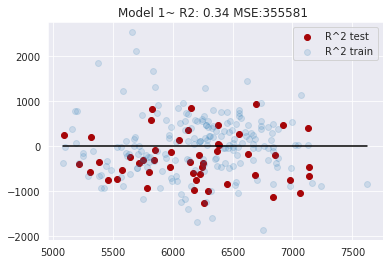

In [42]:
# Make predictions
model = LinearRegression().fit(X_train, Y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate residuals
residual_train = [true_val - estimated_val for true_val, estimated_val in zip(Y_train, y_pred_train)]
residual_test = [true_val - estimated_val for true_val, estimated_val in zip(Y_test, y_pred_test)]


# Plot residuals
plt.scatter(y_pred_test, residual_test, label='R^2 test', color='#A60508')
plt.scatter(y_pred_train, residual_train, label='R^2 train', alpha=0.15)

# Plot [0] line 
plt.plot([min(y_pred_train), max(y_pred_train)], [0,0], color='black')

plt.legend()

plt.title("Model 1~ R2: 0.34 MSE:355581 ")
plt.show()

In [43]:
Usage_comparison = pd.DataFrame(Max_Energy_Usage, columns = ['Predicted_Usage'])

Usage_comparison.set_index(df_new['TOTALDEMAND'], drop = True, inplace = True)

Usage_comparison

,Predicted_Usage
TOTALDEMAND,
5019.64,5642.548000
4964.35,5893.492000
4503.31,5426.941000
4764.18,5402.104000
4800.64,5535.663000
...,...
6769.89,6760.786000
5716.32,6837.297000
6227.89,6979.821000


### Model 2

In [44]:
# Select training set and testing test.
X = df_new[['Minimum temperature (°C)', '9am Temperature (°C)', '3pm Temperature (°C)', 'Evaporation (mm)', 'Sunshine (hours)']]
Y = df_new['TOTALDEMAND']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 1)

X_train.shape

(194, 5)

In [45]:
# Training/fitting of linear regression model
model = LinearRegression().fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("Mean squared error: ", mean_squared_error(Y_test, Y_pred))
print("R2 score: ", model.score(X_test, Y_test))

# Evaluation - square y to determine correct range and context for MSE
#(Y_2**2).describe()

Mean squared error:  383507.72556295304
R2 score:  0.2919402563418714


In [46]:
# Predict value of 'y' based on test fold/subset of 20%
Y_pred = model.predict(X_test)

In [47]:
# Evaluation - generate MSE and R2 score 
print("Mean squared error: ", mean_squared_error(Y_test, Y_pred))
print("R2 score: ", model.score(X_test, Y_test))

# Evaluation - square y to determine correct range and context for MSE
(Y**2).describe()

Mean squared error:  383507.72556295304
R2 score:  0.2919402563418714


count    2.430000e+02
mean     3.834261e+07
std      1.001681e+07
min      2.000818e+07
25%      3.033549e+07
50%      3.887111e+07
75%      4.574514e+07
max      6.718802e+07
Name: TOTALDEMAND, dtype: float64

In [48]:
# Determine intercept and coefficient of linear regression model
# Calculate intercept and coefficient of the prediction model 
intercept = model.intercept_
coefficient = model.coef_
intercept, coefficient

(7153.990586129759,
 array([-204.8497839 ,  106.65394382,   -4.109122  ,   21.23071523,
         -29.85851595]))

In [49]:
# Prediction function 
Min_Temp_2 = X['Minimum temperature (°C)'].values
Temp_9am_2 = X['9am Temperature (°C)'].values
Temp_3pm_2 = X['3pm Temperature (°C)'].values
Evap_2 = X['Evaporation (mm)'].values
Sun_2 = X['Sunshine (hours)'].values
Demand = 7153.99 + -204.85*Min_Temp_2 + 106.65*Temp_9am_2 -4.10*Temp_3pm_2 + 21.23*Evap_2 + 29.86*Sun_2
Demand

array([6227.942     , 5990.405     , 5840.795     , 5610.174     ,
       5677.865     , 6011.197     , 6464.489     , 7040.595     ,
       6779.889     , 6097.396     , 6733.972     , 5835.83      ,
       6342.906     , 6154.66      , 6515.474     , 6755.681     ,
       6470.845     , 6264.508     , 6323.074     , 7265.425     ,
       6757.353     , 6507.634     , 6504.798     , 6546.46      ,
       6190.229     , 5526.384     , 6189.644     , 6286.631     ,
       5320.49      , 5772.058     , 6003.708     , 6336.723     ,
       6055.314     , 6514.268     , 6376.384     , 6505.508     ,
       6053.285     , 5903.038     , 5836.807     , 6866.787     ,
       6548.888     , 6425.855     , 5792.817     , 6167.539     ,
       6698.421     , 6316.5       , 6306.849     , 6298.471     ,
       6377.776     , 6440.164     , 5737.867     , 5467.02      ,
       5959.167     , 6551.561     , 6448.599     , 6555.271     ,
       6257.708     , 6363.22      , 6694.334     , 6340.67   

### Perform residual analysis

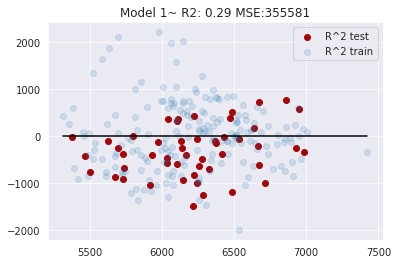

In [50]:
# Make predictions
model = LinearRegression().fit(X_train, Y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate residuals
residual_train = [true_val - estimated_val for true_val, estimated_val in zip(Y_train, y_pred_train)]
residual_test = [true_val - estimated_val for true_val, estimated_val in zip(Y_test, y_pred_test)]


# Plot residuals
plt.scatter(y_pred_test, residual_test, label='R^2 test', color='#A60508')
plt.scatter(y_pred_train, residual_train, label='R^2 train', alpha=0.15)

# Plot [0] line 
plt.plot([min(y_pred_train), max(y_pred_train)], [0,0], color='black')

plt.legend()

plt.title("Model 1~ R2: 0.29 MSE:355581")
plt.show()

In [51]:
# Compare the prediction and actual demand
    
Demand_comp = pd.DataFrame(Demand, columns = ['Prediction'])

Demand_comp.set_index(df_new['TOTALDEMAND'], drop = True, inplace = True)

Demand_comp

,Prediction
TOTALDEMAND,
5019.64,6227.942
4964.35,5990.405
4503.31,5840.795
4764.18,5610.174
4800.64,5677.865
...,...
6769.89,7119.349
5716.32,7288.084
6227.89,6632.135


### Regression with dummy variables

In [52]:
cleaned_data = pd.read_csv('cleaned_data_final.csv')
data_dummies = pd.get_dummies(data = cleaned_data, columns=['PRICECATEGORY'], drop_first=True)
data_dummies

,Date,TOTALDEMAND,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,...,9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),PRICECATEGORY_2,PRICECATEGORY_3,PRICECATEGORY_4
0,1/01/2021,5019.64,15.6,29.9,0.0,2.8,9.3,22.5,31.0,794.0,...,1018.800000,28.1,43,5.0,90.0,13,1015.3,0,0,0
1,2/01/2021,4964.35,18.4,29.0,0.0,9.4,1.3,337.5,30.0,502.0,...,1013.300000,28.7,38,7.0,225.0,4,1008.5,0,0,0
2,3/01/2021,4503.31,17.0,26.2,12.6,4.8,7.1,247.5,33.0,1075.0,...,1007.700000,23.5,59,4.0,202.5,2,1005.2,0,0,0
3,4/01/2021,4764.18,16.0,18.6,2.6,3.8,0.0,157.5,41.0,963.0,...,1010.000000,18.2,82,8.0,202.5,17,1011.0,0,0,0
4,5/01/2021,4800.64,15.9,19.1,11.2,1.0,0.0,157.5,35.0,662.0,...,1012.500000,18.2,82,8.0,157.5,19,1013.3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,27/08/2021,6769.89,4.6,13.6,0.0,1.2,3.8,202.5,15.0,738.0,...,1020.000000,12.8,65,7.0,157.5,7,1017.4,0,0,1
239,28/08/2021,5716.32,5.3,17.8,0.0,1.6,9.6,0.0,39.0,794.0,...,1018.600000,17.4,31,3.0,337.5,24,1013.5,1,0,0
240,29/08/2021,6227.89,9.1,16.2,0.6,6.4,4.3,22.5,33.0,110.0,...,1011.400000,12.8,84,7.0,180.0,6,1010.4,0,0,1
241,30/08/2021,6072.91,6.4,17.6,4.0,1.4,7.4,337.5,50.0,844.0,...,1016.100000,16.8,45,1.0,337.5,28,1013.2,0,1,0


In [53]:
Y_dummy = data_dummies['TOTALDEMAND']
X_dummy = data_dummies[['Minimum temperature (°C)', '9am Temperature (°C)', '3pm Temperature (°C)', 'Evaporation (mm)', 'Sunshine (hours)', 'PRICECATEGORY_2','PRICECATEGORY_3', 'PRICECATEGORY_4']]
           
            

In [54]:
X_train_dummy, X_test_dummy, Y_train_dummy, Y_test_dummy = train_test_split(X_dummy, Y_dummy, test_size = 0.2, random_state = 1)
X_train_dummy.shape

(194, 8)

In [55]:
model_dummy = LinearRegression().fit(X_train_dummy, Y_train_dummy)

#Prediction values for dummy model
intercept_dummy = model_dummy.intercept_
coefficient_dummy = model_dummy.coef_
intercept_dummy, coefficient_dummy

(5220.712976835821,
 array([-9.81484686e+01,  5.65910118e+01,  1.95926348e-01,  6.07063102e+01,
        -2.77872552e+00,  8.05142687e+02,  1.41351880e+03,  1.62583860e+03]))

In [56]:
Min_Temp_dummy = X['Minimum temperature (°C)'].values
Temp_9am_dummy = X['9am Temperature (°C)'].values
Temp_3pm_dummy = X['3pm Temperature (°C)'].values
Evap_dummy = X['Evaporation (mm)'].values
Sun_dummy = X['Sunshine (hours)'].values
price_2_dummy = X['Sunshine (hours)'].values
price_3_dummy = X['Sunshine (hours)'].values
price_4_dummy = X['Sunshine (hours)'].values

Daily_Max_Demand_dummy = 5220.712976835819 -9.81*Min_Temp_dummy +  5.66*Temp_9am_dummy + 1.96*Temp_3pm_dummy + 6.07*Evap_dummy -2.78*Sun_dummy, + 8.05*price_2_dummy + 1.41*price_3_dummy + 1.63*price_4_dummy

Daily_Max_Demand_dummy

(array([5222.56697684, 5281.78297684, 5212.97897684, 5214.18297684,
        5203.82797684, 5204.99797684, 5217.62397684, 5269.74597684,
        5247.36497684, 5238.36597684, 5306.06897684, 5247.57397684,
        5246.93797684, 5228.14497684, 5237.10897684, 5268.13097684,
        5220.94197684, 5221.73397684, 5226.56897684, 5265.87797684,
        5260.61197684, 5248.65297684, 5237.24597684, 5286.87597684,
        5303.99697684, 5235.04997684, 5205.01797684, 5279.77897684,
        5210.53197684, 5206.15397684, 5195.22697684, 5263.40697684,
        5217.41997684, 5223.30197684, 5272.09197684, 5260.77397684,
        5234.87197684, 5226.77197684, 5219.37097684, 5233.28897684,
        5250.82497684, 5285.11697684, 5250.28297684, 5236.44397684,
        5236.46397684, 5229.16497684, 5252.81797684, 5236.58497684,
        5266.29197684, 5255.51497684, 5256.49197684, 5221.21997684,
        5204.94797684, 5240.77197684, 5218.86897684, 5242.58797684,
        5234.87397684, 5254.79797684, 5236.11497

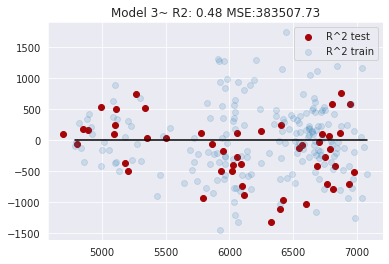

In [57]:
# Make predictions
model_dummy = LinearRegression().fit(X_train_dummy, Y_train_dummy)

y_pred_train_dummy  = model_dummy .predict(X_train_dummy)
y_pred_test_dummy  = model_dummy .predict(X_test_dummy)

# Calculate residuals
residual_train_dummy  = [true_val - estimated_val for true_val, estimated_val in zip(Y_train_dummy , y_pred_train_dummy )]
residual_test_dummy  = [true_val - estimated_val for true_val, estimated_val in zip(Y_test_dummy , y_pred_test_dummy )]


# Plot residuals
plt.scatter(y_pred_test_dummy , residual_test_dummy , label='R^2 test', color='#A60508')
plt.scatter(y_pred_train_dummy , residual_train_dummy , label='R^2 train', alpha=0.15)

# Plot [0] line 
plt.plot([min(y_pred_train_dummy ), max(y_pred_train_dummy)], [0,0], color='black')

plt.legend()

plt.title("Model 3~ R2: 0.48 MSE:383507.73")
plt.show()

# Classification Tree

In [58]:
# Define Classification Tree variables
# Select independent variables with highest R-square value
df_new = pd.read_csv('cleaned_data_final.csv')
Y_class = df_new['PRICECATEGORY']
X_class = df_new.drop(['Date', 'PRICECATEGORY'], axis = 1)

In [59]:
# Split dataset into training subsets (80%) and testing (20%) 
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, Y_class, train_size=0.8, test_size=0.2, random_state=42)
X_train_class.head(10)

,TOTALDEMAND,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
115,6436.32,10.9,17.9,1.2,2.2,0.8,202.5,20.0,650.0,13.6,...,7,225.0,6,1027.9,16.1,68,7.0,180.0,9,1027.1
207,6646.82,10.1,17.1,0.0,3.4,4.3,0.0,67.0,1300.0,11.1,...,2,0.0,19,1011.1,16.4,48,7.0,0.0,26,1003.7
158,7228.52,9.3,13.2,3.0,4.8,2.3,0.0,48.0,39.0,9.3,...,7,22.5,9,1005.0,11.1,72,7.0,270.0,11,1004.8
132,6679.05,8.1,17.6,0.0,1.2,1.0,337.5,39.0,717.0,14.0,...,7,0.0,15,1012.5,13.1,90,8.0,315.0,9,1011.1
84,5651.13,11.2,22.0,0.2,2.8,6.5,0.0,33.0,725.0,13.3,...,1,45.0,9,1013.7,20.4,46,7.0,337.5,17,1011.0
55,5504.37,11.3,24.3,0.0,5.8,8.7,202.5,39.0,1148.0,13.4,...,7,90.0,4,1012.8,23.4,37,2.0,270.0,11,1009.1
86,5019.74,12.4,20.2,0.0,4.4,3.9,202.5,24.0,670.0,14.2,...,6,337.5,7,1018.8,18.3,55,7.0,202.5,9,1018.6
162,6062.58,7.4,16.5,9.4,0.4,1.0,292.5,33.0,752.0,12.7,...,7,292.5,7,1014.4,15.5,61,7.0,270.0,11,1014.0
178,7214.06,6.4,15.1,0.0,1.4,9.0,337.5,24.0,747.0,7.8,...,1,22.5,7,1032.8,14.6,53,1.0,22.5,9,1031.0
224,6300.74,8.1,17.6,0.0,1.2,10.1,315.0,33.0,784.0,11.8,...,1,0.0,15,1026.9,17.1,44,3.0,270.0,9,1025.1


In [60]:
# Define options for Decision Tree classification
dt = DecisionTreeClassifier(criterion="entropy", random_state = 42, max_depth = 3)
dt.fit(X_train_class, y_train_class)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)

In [61]:
# Assign y_pred to decision tree predictions based on X_test
y_pred_class = dt.predict(X_test_class)
y_pred_class

array([3, 1, 4, 2, 3, 4, 4, 4, 4, 2, 2, 4, 3, 3, 2, 4, 4, 1, 2, 2, 2, 2,
       2, 1, 4, 4, 3, 2, 1, 3, 4, 4, 1, 2, 1, 2, 2, 4, 4, 4, 2, 3, 4, 1,
       4, 2, 4, 1, 4])

In [62]:
# Evaluation - apply accuracy score
accuracy_score(y_test_class, y_pred_class)


0.4489795918367347

number of bins = 4, accuracy score = 0.6327
number of bins = 5, accuracy score = 0.4694
number of bins = 6, accuracy score = 0.4286
number of bins = 8, accuracy score = 0.2449
number of bins = 10, accuracy score = 0.3265
number of bins = 20, accuracy score = 0.1224
number of bins = 25, accuracy score = 0.1224
number of bins = 50, accuracy score = 0.0204
number of bins = 100, accuracy score = 0.0000


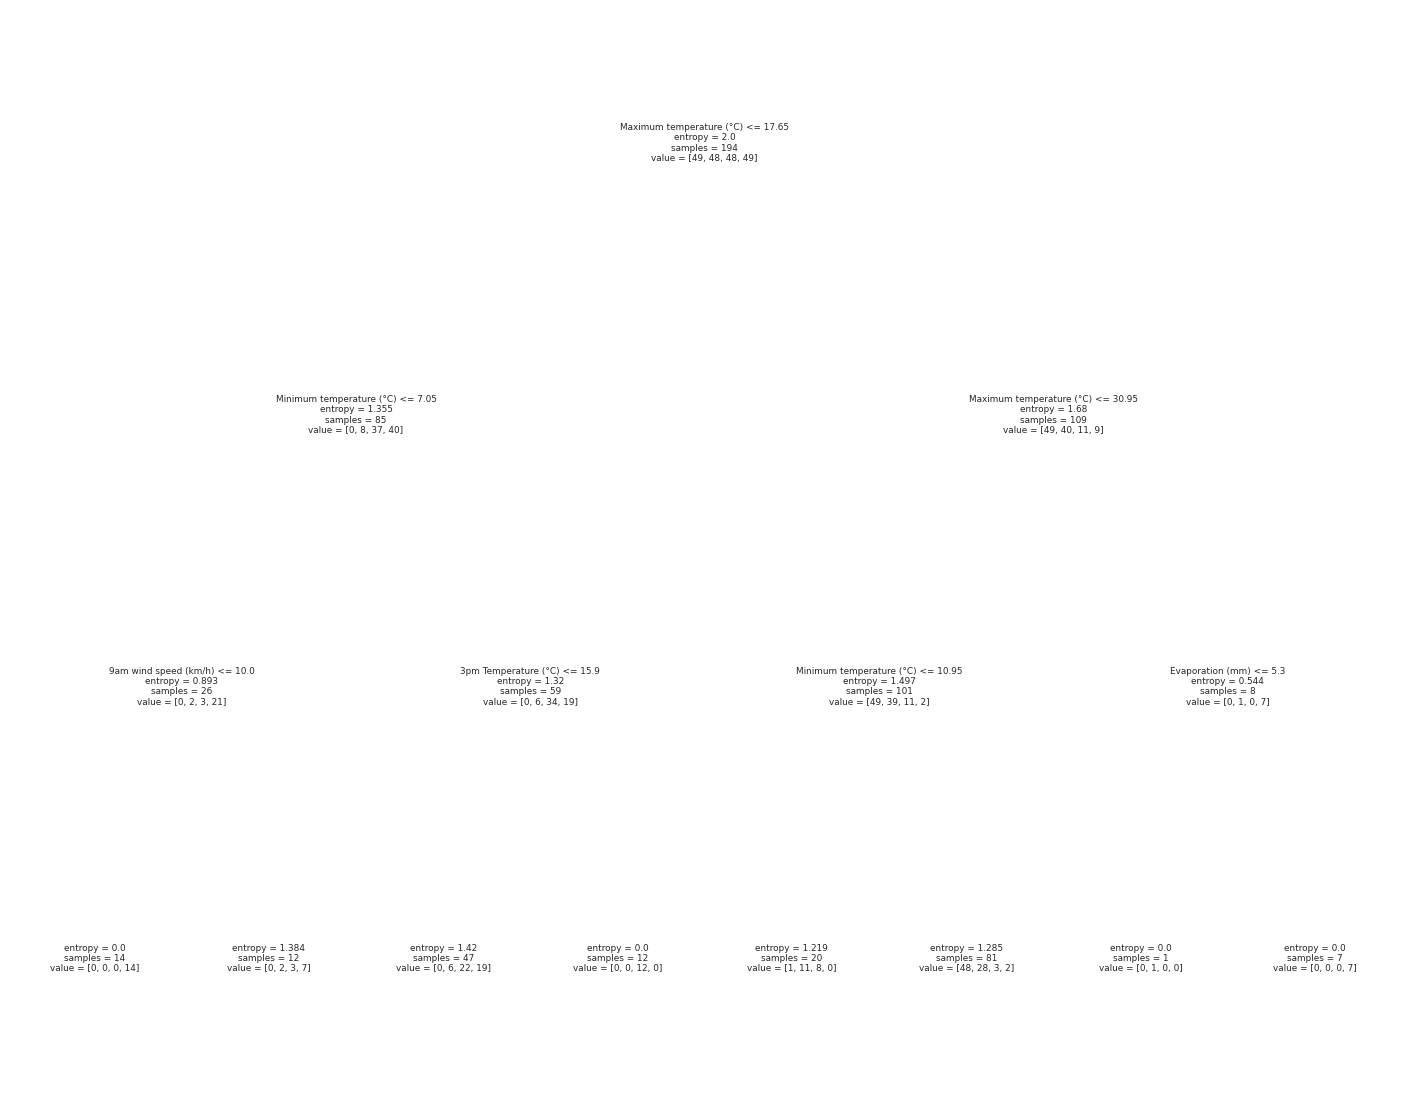

In [63]:
# Plot decision tree
features_all = False

if features_all:
    feature_list = list(pd.read_csv('cleaned_data_final.csv').columns)
    print(feature_list)
else:
    feature_list = ['Minimum temperature (°C)', 'Maximum temperature (°C)', '9am wind direction', '9am Temperature (°C)', 
                    '3pm Temperature (°C)', 'Evaporation (mm)', 'Sunshine (hours)', 
                    'Speed of maximum wind gust (km/h)', '9am cloud amount (oktas)', '9am wind speed (km/h)', '9am MSL pressure (hPa)', 
                    '3pm relative humidity (%)', '3pm cloud amount (oktas)', '3pm wind direction', '3pm wind speed (km/h)', 
                   '3pm MSL pressure (hPa)']

features = df_new[feature_list]

for n_bin in [4,5,6,8,10,20,25,50,100]:  
    classlabel = pd.qcut(df_new['TOTALDEMAND'], q=n_bin).cat.codes
    
    features_train, features_test, class_train, class_test = train_test_split(features, classlabel, train_size=0.8, test_size=0.2, random_state=42)

    dtc = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=3)
    dtc.fit(features_train, class_train)

    predictions = dtc.predict(features_test)
    print(f"number of bins = {n_bin}, accuracy score = {accuracy_score(class_test, predictions):.4f}")

    if n_bin == 4:
        fig = plt.figure(figsize=(25, 20))
        tree.plot_tree(dtc, feature_names = feature_list)

## KNN

Best Score:  0.6758771929824561
Parameters:  {'n_neighbors': 9}
Average score:  0.5941485025695553
Average std:  0.07691962765143597
Metric Used:  euclidean


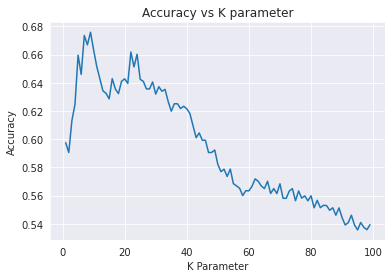

Model Accuracy on test data:  0.6530612244897959


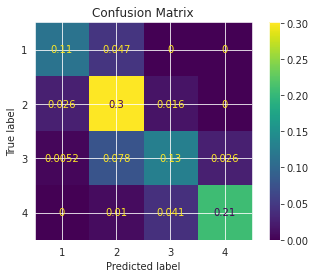

In [64]:
df_new = pd.read_csv('cleaned_data_final.csv')
features_knn = df_new[['TOTALDEMAND', 
            'PRICECATEGORY', 
            'Minimum temperature (°C)', 
            'Maximum temperature (°C)', 
            'Rainfall (mm)',
            'Evaporation (mm)', 
            'Sunshine (hours)',
            #'Direction of maximum wind gust',
            'Speed of maximum wind gust (km/h)',
            'Time of maximum wind gust',
            '9am cloud amount (oktas)',
            #'9am wind direction',
            '9am wind speed (km/h)',
            '9am MSL pressure (hPa)',
            '3pm Temperature (°C)',
            '3pm relative humidity (%)',
            '3pm cloud amount (oktas)',
            '3pm wind direction',
            '3pm wind speed (km/h)',
            '3pm MSL pressure (hPa)']].astype(float)


# Price category max as class label.
classlabel = df_new['PRICECATEGORY']

# Splits the data in to training and test set - will build on this to explore if split improves model.
features_train, features_test, class_train, class_test = train_test_split(features_knn, classlabel, train_size=0.80, test_size=0.20)

# Scale features to reduce distance between low and large weighted data.
scaler = preprocessing.StandardScaler().fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

# Remove outliers from training set.
lof = LocalOutlierFactor()
yhat = lof.fit_predict(features_train)
mask = yhat != -1
features_train, class_train = features_train[mask, :], class_train[mask]

# Range for value K to tune in model.
ks = range(1,100)

# Parameters to be tuned in cross validation - can explore these further.
parameters = [{'n_neighbors': ks}]

# Cross validation 
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3, random_state=42)

# GridSearchCV sets up grid search to search for best paramters, uses 10 KFolds.
clf = GridSearchCV(neighbors.KNeighborsClassifier(), parameters, cv = cv)
clf.fit(features_train, class_train)

print("Best Score: ", clf.best_score_)
print("Parameters: ", clf.best_params_)
print("Average score: ", sum(clf.cv_results_['mean_test_score']) / len(clf.cv_results_['mean_test_score']))
avg_std = (sum(clf.cv_results_['std_test_score']) / len(clf.cv_results_['std_test_score']))
print('Average std: ', avg_std)
print('Metric Used: ', clf.best_estimator_.effective_metric_)

# Plot k value vs accuracy.
plt.plot(ks, clf.cv_results_['mean_test_score'])
plt.title('Accuracy vs K parameter')
plt.xlabel('K Parameter')
plt.ylabel('Accuracy')
plt.show()

# Set best k value from cross validation and create and train new model to test.
best_k = clf.best_params_['n_neighbors']
knn = neighbors.KNeighborsClassifier(n_neighbors=best_k)
knn.fit(features_train, class_train)
predic = knn.predict(features_test)
test_accuracy = accuracy_score(class_test, predic)
print('Model Accuracy on test data: ', test_accuracy)


# Plot confusion matrix to model with tuned parameters performed.
plot_confusion_matrix(clf, features_train, class_train, normalize='all')
plt.title('Confusion Matrix')
plt.show()